In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import query_weather_data
import forecastData

# Testing simple machine learning bias correction site forecast

1. Get Obs

In this method we want to use a single site (we are not using surrounding sites)

In [2]:
siteObs = query_weather_data.retrieve_data('../../weather_observations.db', 'Brisbane')
siteObs.index = pd.to_datetime(siteObs.date)
siteObs = siteObs.sort_index()

Generated Query: SELECT * FROM observations WHERE 1=1 AND name = 'Brisbane' AND date BETWEEN '20240923122318' AND '20241003122318'


<Axes: xlabel='date'>

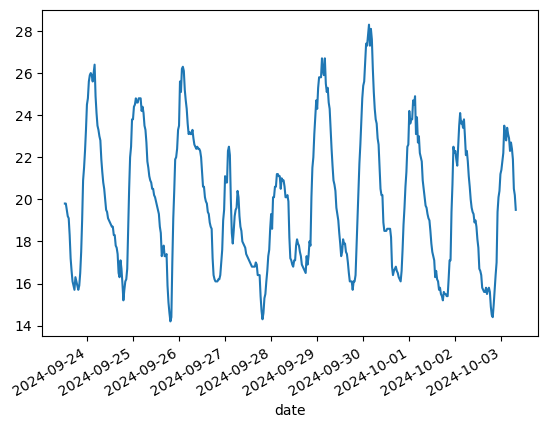

In [3]:
siteObs.air_temp.plot()

In [4]:
siteObs.head(1)

,id,date,station_id,name,latitude,longitude,apparent_t,gust_kmh,gust_kt,air_temp,dewpt,press,press_msl,rel_hum,wind_direction_deg,wind_speed_kmh
date,,,,,,,,,,,,,,,,
2024-09-23 12:30:00,237669,20240923123000,94576,Brisbane,-27.4808,153.0389,21.4,9.0,5.0,19.8,17.0,1022.4,1022.4,84.0,330.0,4.0


2. Get the latest forecast and historic forecasts

In [5]:
forecast = forecastData.getData([siteObs.iloc[0]['latitude']], [siteObs.iloc[0]['longitude']], [siteObs.iloc[0]['name']], pastDays = 92)

<Axes: xlabel='time'>

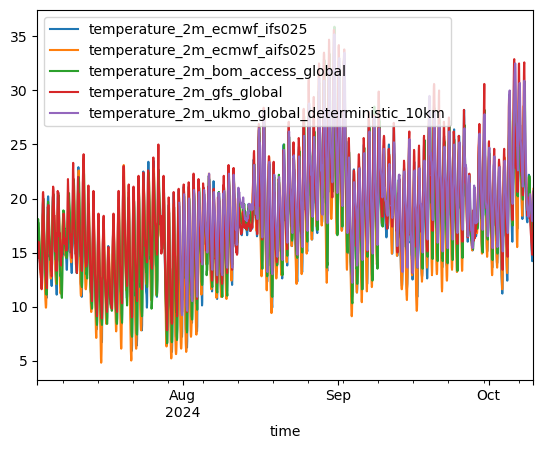

In [6]:
forecast[[col for col in forecast.columns if 'temperature' in col]].plot()

## Check data for overlaps

<Axes: xlabel='date'>

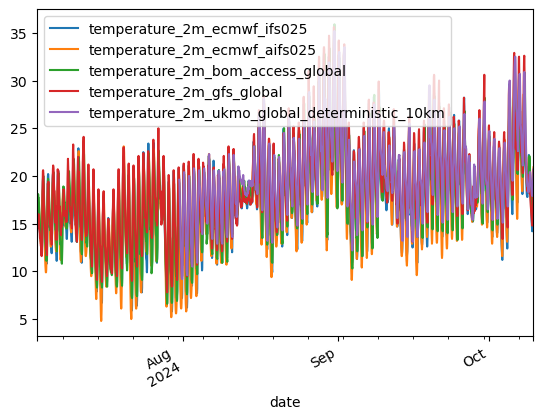

In [7]:
forecast[[col for col in forecast.columns if 'temperature' in col]].plot()
siteObs.air_temp.plot(color = 'black')

In [8]:
print(forecast.head(3))

                     temperature_2m_ecmwf_ifs025  \
time                                               
2024-07-03 00:00:00                         14.9   
2024-07-03 01:00:00                         15.4   
2024-07-03 02:00:00                         15.9   

                     relative_humidity_2m_ecmwf_ifs025  \
time                                                     
2024-07-03 00:00:00                                 91   
2024-07-03 01:00:00                                 89   
2024-07-03 02:00:00                                 87   

                     cloud_cover_ecmwf_ifs025  wind_speed_10m_ecmwf_ifs025  \
time                                                                         
2024-07-03 00:00:00                        82                         10.9   
2024-07-03 01:00:00                        75                         11.5   
2024-07-03 02:00:00                        60                         12.2   

                     wind_direction_10m_ecmwf_ifs025  \
t

In [9]:
print(siteObs.head(3))

                         id            date station_id      name  latitude  \
date                                                                         
2024-09-23 12:30:00  237669  20240923123000      94576  Brisbane  -27.4808   
2024-09-23 12:30:00  345889  20240923123000      94576  Brisbane  -27.4808   
2024-09-23 12:30:00   21268  20240923123000      94576  Brisbane  -27.4808   

                     longitude  apparent_t  gust_kmh  gust_kt  air_temp  \
date                                                                      
2024-09-23 12:30:00   153.0389        21.4       9.0      5.0      19.8   
2024-09-23 12:30:00   153.0389        21.4       9.0      5.0      19.8   
2024-09-23 12:30:00   153.0389        21.4       9.0      5.0      19.8   

                     dewpt   press  press_msl  rel_hum  wind_direction_deg  \
date                                                                         
2024-09-23 12:30:00   17.0  1022.4     1022.4     84.0               330.0   

<Axes: xlabel='time'>

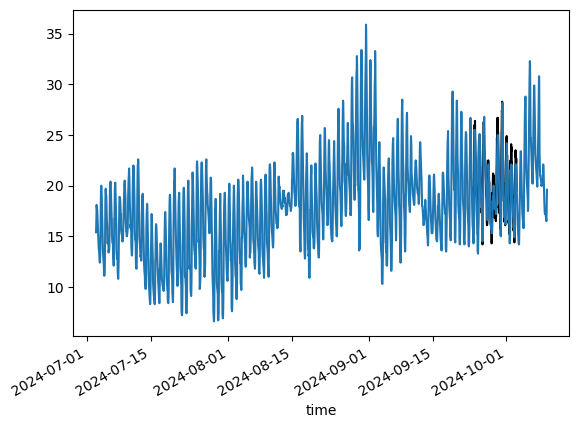

In [10]:
siteObs.air_temp.plot(color = 'black')
forecast['temperature_2m_bom_access_global'].plot()

3. Join the forecast and obs data for training

In [11]:
df = forecast.join(siteObs[['apparent_t', 'gust_kmh', 'gust_kt', 'air_temp', 'dewpt', 'press',
       'press_msl', 'rel_hum', 'wind_direction_deg', 'wind_speed_kmh']], how='inner', rsuffix='_obs')

In [17]:
featureCols = ['temperature_2m_ecmwf_ifs025', 'relative_humidity_2m_ecmwf_ifs025',
       'cloud_cover_ecmwf_ifs025', 'wind_speed_10m_ecmwf_ifs025',
       'wind_direction_10m_ecmwf_ifs025', 'temperature_2m_ecmwf_aifs025',
       'relative_humidity_2m_ecmwf_aifs025', 'cloud_cover_ecmwf_aifs025',
       'wind_speed_10m_ecmwf_aifs025', 'wind_direction_10m_ecmwf_aifs025',
       'temperature_2m_bom_access_global',
       'relative_humidity_2m_bom_access_global',
       'cloud_cover_bom_access_global', 'wind_speed_10m_bom_access_global',
       'wind_direction_10m_bom_access_global', 'temperature_2m_gfs_global',
       'relative_humidity_2m_gfs_global', 'cloud_cover_gfs_global',
       'wind_speed_10m_gfs_global', 'wind_direction_10m_gfs_global',
       'temperature_2m_ukmo_global_deterministic_10km',
       'relative_humidity_2m_ukmo_global_deterministic_10km',
       'cloud_cover_ukmo_global_deterministic_10km',
       'wind_speed_10m_ukmo_global_deterministic_10km',
       'wind_direction_10m_ukmo_global_deterministic_10km']

In [12]:
targetParam = 'air_temp'

4. Train Model

In [20]:
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df[featureCols], df[targetParam], test_size=0.2, shuffle=False)

In [22]:
# Initialize and train XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [23]:
y_pred = model.predict(X_test)

In [26]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

0.8836908191255579